In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    
    #bce = keras.losses.BinaryCrossentropy()
    #loss_term = bce(x, x_decoded)

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term = 1/2 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1,1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, dim))
        return z_mean + tf.exp(1/2*z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim,))

x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │      2,570 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │      2,570 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 10)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 271,892 (1.04 MB)

 Trainable params: 271,892 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,096 (1.03 MB)

 Trainable params: 270,096 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 223.4616 - total_loss: 182.2572
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 140.1087 - total_loss: 135.8845
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 127.2085 - total_loss: 125.5158
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 120.6231 - total_loss: 119.4931
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 116.2234 - total_loss: 115.9320
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 113.8320 - total_loss: 113.6094
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 112.0585 - total_loss: 111.9287
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 110.4862 - total_loss: 110.5365
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 109.2571 - total_loss: 109.4921
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 108.5092 - total_loss: 108.5372


## f)

In [12]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

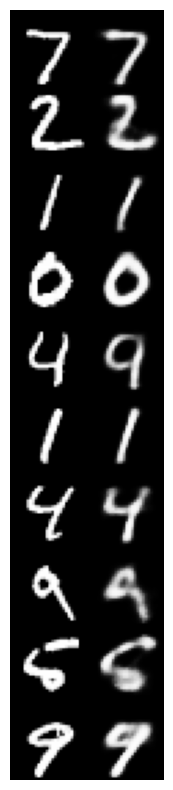

In [14]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [15]:
# use z_test_pred

In [16]:
from sklearn.manifold import TSNE

In [17]:
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

c:\Users\Jakub\Documents\General_Environment\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Jakub\Documents\General_Environment\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


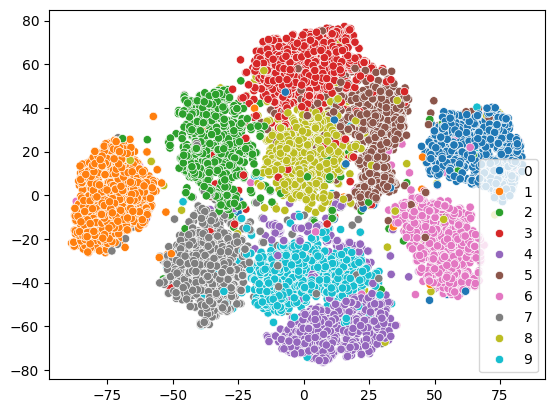

In [18]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

# h

In [19]:
# Sampling based on given x

In [25]:
z_test_pred[0][2]

array([ 2.7333581 , -0.45903182, -0.35746577, -0.57759345, -0.1284982 ,
       -0.67622805, -0.86260587,  0.5241076 ,  0.46286228,  0.5117347 ],
      dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


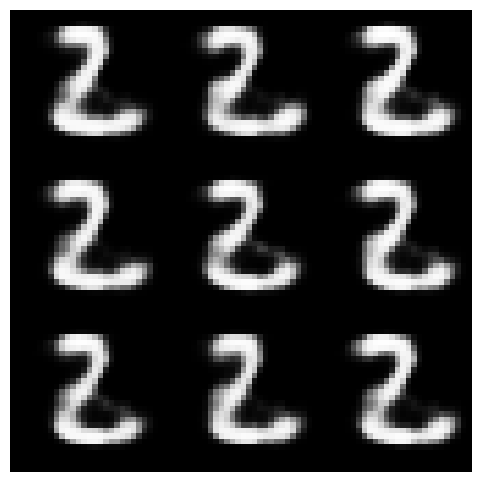

In [29]:
n = 3  # Number of rows
m = 3  # Number of columns
digit_size = int(np.sqrt(original_dim))  # Assuming original_dim contains the size of each digit image
fig = plt.figure(figsize=(m * 2, n * 2))
figure = np.zeros((digit_size * n, digit_size * m))

for i in range(n):
    for j in range(m):
        # Sample latent vector
        z = Sampling()((z_test_pred[0][1].reshape(1,-1), z_test_pred[1][1].reshape(1,-1)))  # Assuming z_test_pred contains mean and log variance

        # Decode sampled latent vector
        decoded = decoder.predict(z)

        # Place the decoded digit in the figure
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_start = j * digit_size
        col_end = (j + 1) * digit_size
        figure[row_start:row_end, col_start:col_end] = decoded.reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


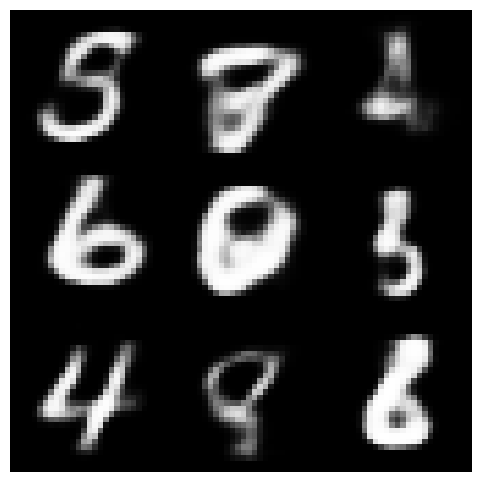

In [30]:
n = 3  # Number of rows
m = 3  # Number of columns
digit_size = int(np.sqrt(original_dim))  # Assuming original_dim contains the size of each digit image
fig = plt.figure(figsize=(m * 2, n * 2))
figure = np.zeros((digit_size * n, digit_size * m))

for i in range(n):
    for j in range(m):
        # Sample latent vector
        z = np.random.randn(1,10)  # Assuming z_test_pred contains mean and log variance

        # Decode sampled latent vector
        decoded = decoder.predict(z)

        # Place the decoded digit in the figure
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_start = j * digit_size
        col_end = (j + 1) * digit_size
        figure[row_start:row_end, col_start:col_end] = decoded.reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# TASK 3

In [116]:
# Training more complex model proved to be very time consuming, although there is still room for improvement.

In [31]:
# Encoder
latent_dim = 20
encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(512, activation='relu')(encoder_inputs)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='tanh')(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(512, activation='relu')(latent_inputs)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [108]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.val_loss = keras.metrics.Mean(name="val_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}      
    
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        val_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        self.val_loss.update_state(val_loss)

        return {"loss": self.val_loss.result()} 
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.val_loss]

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_val_loss', mode = "min",patience=5, restore_best_weights=True
)

In [54]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(
    x_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_test, None))#, 
    #callbacks=[early_stopping])

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 110.0848 - total_loss: 110.0814 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 112.0783
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 109.5465 - total_loss: 109.9055 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 112.1973
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 109.6073 - total_loss: 109.8290 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 112.1384
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 109.5384 - total_loss: 109.9731 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 111.9246
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 109.4087 - total_loss: 109.6637 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 112.1353
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 110.1005 - total_loss: 110.2754 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+0

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


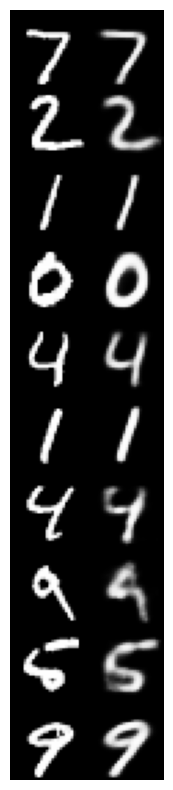

In [55]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2])
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

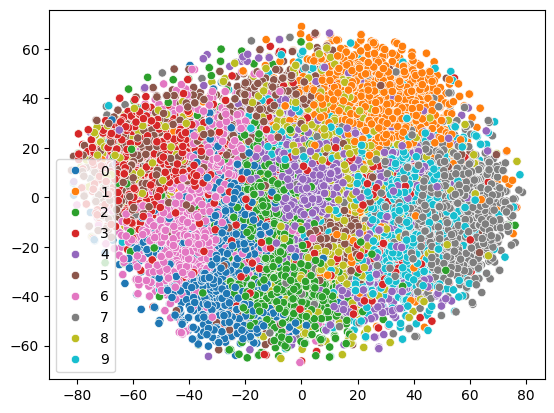

In [56]:
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


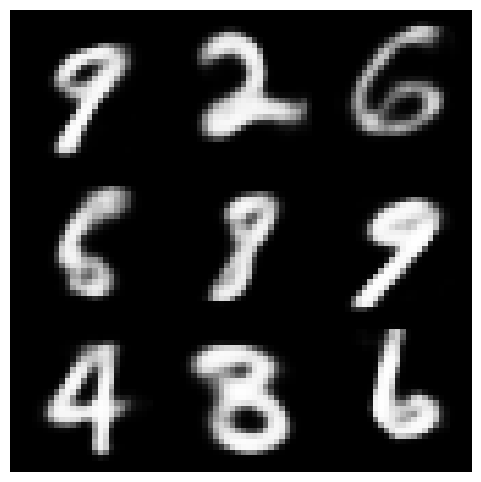

In [63]:
n = 3  # Number of rows
m = 3  # Number of columns
digit_size = int(np.sqrt(original_dim))  # Assuming original_dim contains the size of each digit image
fig = plt.figure(figsize=(m * 2, n * 2))
figure = np.zeros((digit_size * n, digit_size * m))

for i in range(n):
    for j in range(m):
        # Sample latent vector
        z = np.random.randn(1,20)  # Assuming z_test_pred contains mean and log variance

        # Decode sampled latent vector
        decoded = decoder.predict(z)

        # Place the decoded digit in the figure
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_start = j * digit_size
        col_end = (j + 1) * digit_size
        figure[row_start:row_end, col_start:col_end] = decoded.reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

In [64]:
# Encoder
latent_dim = 10
encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(512, activation='relu')(encoder_inputs)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='tanh')(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(512, activation='relu')(latent_inputs)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [87]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(
    x_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_test, None))

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 114.0561 - total_loss: 113.5937 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 114.5755
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 113.5508 - total_loss: 113.4314 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 114.8798
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 113.3136 - total_loss: 113.3535 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 114.3433
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 113.1280 - total_loss: 113.3061 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 114.7520
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 113.5049 - total_loss: 113.2612 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - val_val_loss: 114.1330
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 112.9010 - total_loss: 113.1493 - val_loss: 0.0000e+00 - val_total_loss: 0.0000e+0

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


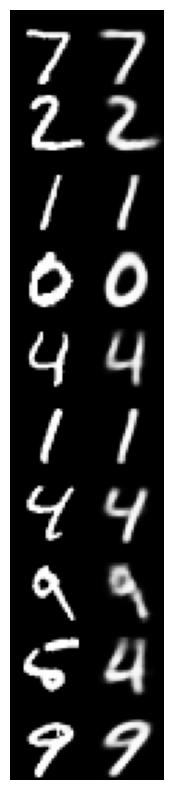

In [88]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[2])
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

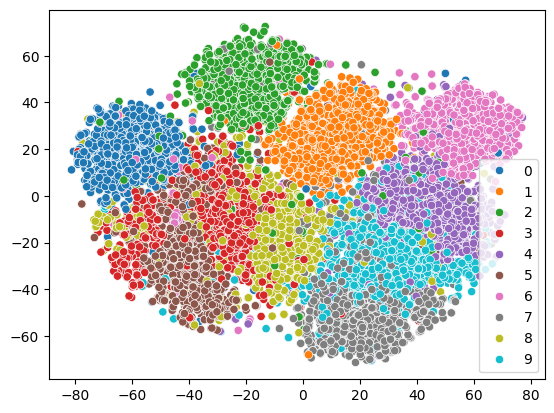

In [89]:
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


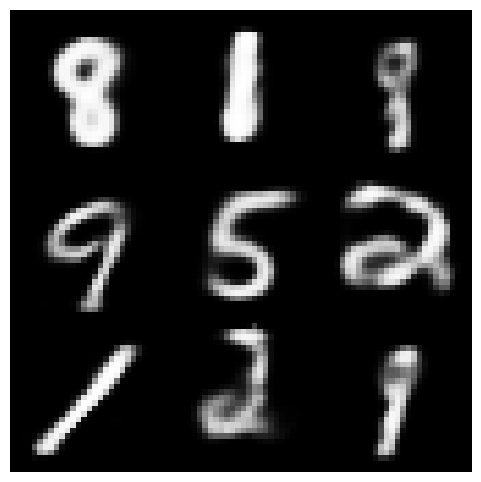

In [112]:
n = 3  # Number of rows
m = 3  # Number of columns
digit_size = int(np.sqrt(original_dim))  # Assuming original_dim contains the size of each digit image
fig = plt.figure(figsize=(m * 2, n * 2))
figure = np.zeros((digit_size * n, digit_size * m))

for i in range(n):
    for j in range(m):
        # Sample latent vector
        z = np.random.randn(1,10)  # Assuming z_test_pred contains mean and log variance

        # Decode sampled latent vector

        decoded = decoder.predict(z)

        # Place the decoded digit in the figure
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_start = j * digit_size
        col_end = (j + 1) * digit_size
        figure[row_start:row_end, col_start:col_end] = decoded.reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## sampling number 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


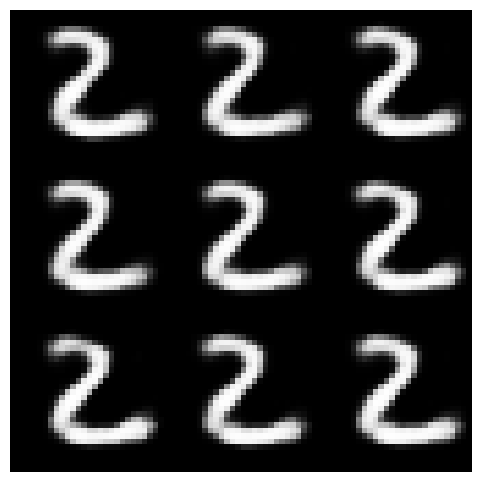

In [114]:
n = 3  # Number of rows
m = 3  # Number of columns
digit_size = int(np.sqrt(original_dim))  # Assuming original_dim contains the size of each digit image
fig = plt.figure(figsize=(m * 2, n * 2))
figure = np.zeros((digit_size * n, digit_size * m))

for i in range(n):
    for j in range(m):
        # Sample latent vector
        z = Sampling()((z_test_pred[0][1].reshape(1,-1), z_test_pred[1][1].reshape(1,-1)))  # Assuming z_test_pred contains mean and log variance

        # Decode sampled latent vector
        decoded = decoder.predict(z)

        # Place the decoded digit in the figure
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_start = j * digit_size
        col_end = (j + 1) * digit_size
        figure[row_start:row_end, col_start:col_end] = decoded.reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## sampling number 7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


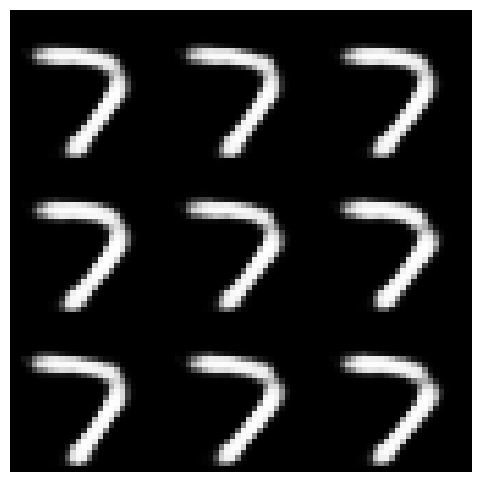

In [115]:
n = 3  # Number of rows
m = 3  # Number of columns
digit_size = int(np.sqrt(original_dim))  # Assuming original_dim contains the size of each digit image
fig = plt.figure(figsize=(m * 2, n * 2))
figure = np.zeros((digit_size * n, digit_size * m))

for i in range(n):
    for j in range(m):
        # Sample latent vector
        z = Sampling()((z_test_pred[0][17].reshape(1,-1), z_test_pred[1][17].reshape(1,-1)))  # Assuming z_test_pred contains mean and log variance

        # Decode sampled latent vector
        decoded = decoder.predict(z)

        # Place the decoded digit in the figure
        row_start = i * digit_size
        row_end = (i + 1) * digit_size
        col_start = j * digit_size
        col_end = (j + 1) * digit_size
        figure[row_start:row_end, col_start:col_end] = decoded.reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

In [ ]:
# After over 400 epochs of training the results are fine, but it's clear from the pictures and the validation loss that the training is not done.